# Moving MNIST Dataset R&D

In [45]:
import os
import errno

import numpy as np
import torch
import matplotlib.pyplot as plt

In [46]:
%matplotlib inline

## Moving MNIST version 1

http://www.cs.toronto.edu/~nitish/unsupervised_video/

A pytorch dataset implementation: https://github.com/tychovdo/MovingMNIST

In [13]:
class MovingMNIST(torch.utils.data.Dataset):
    """`MovingMNIST <http://www.cs.toronto.edu/~nitish/unsupervised_video/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        split (int, optional): Train/test split size. Number defines how many samples
            belong to test set. 
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in an PIL
            image and returns a transformed version. E.g, ``transforms.RandomCrop``
    """
    urls = [
        'https://github.com/tychovdo/MovingMNIST/raw/master/mnist_test_seq.npy.gz'
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'moving_mnist_train.pt'
    test_file = 'moving_mnist_test.pt'

    def __init__(self, root, train=True, split=1000, transform=None, target_transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.split = split
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        data_file = self.training_file if self.train else self.test_file
        self.data = torch.load(os.path.join(self.root, self.processed_folder, data_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (seq, target) where sampled sequences are splitted into a seq
                    and target part
        """
        return self.data[index, :10], self.data[index, 10:]

    def __len__(self):
        return len(self.data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    def download(self):
        """Download the Moving MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        training_set = torch.from_numpy(
            np.load(os.path.join(self.root, self.raw_folder, 'mnist_test_seq.npy')).swapaxes(0, 1)[:-self.split]
        )
        test_set = torch.from_numpy(
            np.load(os.path.join(self.root, self.raw_folder, 'mnist_test_seq.npy')).swapaxes(0, 1)[-self.split:]
        )

        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train else 'test'
        fmt_str += '    Train/test: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [6]:
data_dir = os.path.expandvars('$SCRATCH/moving-mnist')
data_dir

'/global/cscratch1/sd/sfarrell/moving-mnist'

In [22]:
train_data = MovingMNIST(data_dir, train=True, download=True)
test_data = MovingMNIST(data_dir, train=False)

In [23]:
train_data

Dataset MovingMNIST
    Number of datapoints: 9000
    Train/test: train
    Root Location: $SCRATCH/moving-mnist
    Transforms (if any): None
    Target Transforms (if any): None

In [24]:
test_data

Dataset MovingMNIST
    Number of datapoints: 1000
    Train/test: test
    Root Location: $SCRATCH/moving-mnist
    Transforms (if any): None
    Target Transforms (if any): None

## Moving MNIST version 2

https://onedrive.live.com/?authkey=%21AGzXjcOlzTQw158&id=FF7F539F0073B9E2%21124&cid=FF7F539F0073B9E2

https://github.com/ML4HPC/predrnn-pp

The data loading code in the github link above is overly complicated. Also, the npz files contain unnecessary information related to the shape and indices in the data.

In [47]:
data_dir = '/global/cfs/cdirs/m1759/sfarrell/nesap-stl/data'

In [48]:
!ls $data_dir

brain_mnist.npy  moving-mnist-test.npz	 moving-mnist-valid.npz  traffic.txt
electricity.txt  moving-mnist-train.npz  solar_AL.txt


In [49]:
f = np.load(os.path.join(data_dir, 'moving-mnist-train.npz'))
list(f.keys()), f['clips'].shape, f['dims'].shape, f['input_raw_data'].shape

(['clips', 'dims', 'input_raw_data'],
 (2, 10000, 2),
 (1, 3),
 (200000, 1, 64, 64))

In [50]:
f = np.load(os.path.join(data_dir, 'moving-mnist-valid.npz'))
list(f.keys()), f['clips'].shape, f['dims'].shape, f['input_raw_data'].shape

(['clips', 'dims', 'input_raw_data'], (2, 2000, 2), (1, 3), (40000, 1, 64, 64))

In [51]:
f = np.load(os.path.join(data_dir, 'moving-mnist-test.npz'))
list(f.keys()), f['clips'].shape, f['dims'].shape, f['input_raw_data'].shape

(['clips', 'dims', 'input_raw_data'], (2, 3000, 2), (1, 3), (60000, 1, 64, 64))

### Making pytorch dataset

In [52]:
class MovingMNIST(torch.utils.data.Dataset):
    """Moving MNIST dataset

    TODO: add more documentation
    """

    def __init__(self, data_file, sample_shape=(20, 1, 64, 64), input_seq_length=10):
        self.data_file = data_file
        self.input_seq_length = input_seq_length
        
        # Load the data
        with np.load(data_file) as f:
            d = f['input_raw_data']

        # Reshape and convert to torch
        self.data = torch.tensor(d.reshape((-1,) + sample_shape))
    
    def __getitem__(self, index):
        return (self.data[index, :self.input_seq_length],
                self.data[index, self.input_seq_length:])

    def __len__(self):
        return len(self.data)

In [53]:
train_data = MovingMNIST(os.path.join(data_dir, 'moving-mnist-train.npz'))

In [54]:
train_data

In [55]:
x, y = train_data[2]

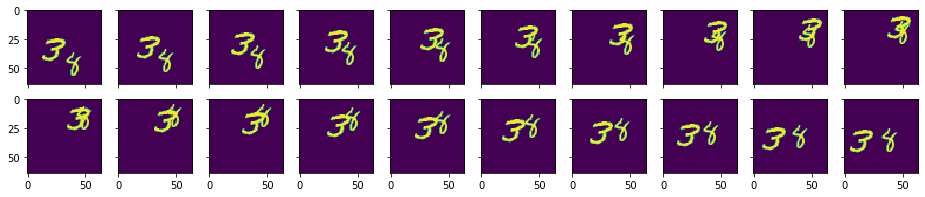

In [56]:
fig, (axs0, axs1) = plt.subplots(nrows=2, ncols=10, figsize=(16, 3), sharex=True, sharey=True)
for i in range(10):
    axs0[i].imshow(x[i,0])
    axs1[i].imshow(y[i,0])

In [66]:
x.shape

torch.Size([10, 1, 64, 64])

### Testing patch reshape

In [57]:
def reshape_patch(img_tensor, patch_size):
    assert 5 == img_tensor.ndim
    batch_size = np.shape(img_tensor)[0]
    seq_length = np.shape(img_tensor)[1]
    img_height = np.shape(img_tensor)[2]
    img_width = np.shape(img_tensor)[3]
    num_channels = np.shape(img_tensor)[4]
    a = np.reshape(img_tensor, [batch_size, seq_length,
                                img_height//patch_size, patch_size,
                                img_width//patch_size, patch_size,
                                num_channels])
    b = np.transpose(a, [0,1,2,4,3,5,6])
    patch_tensor = np.reshape(b, [batch_size, seq_length,
                                  img_height//patch_size,
                                  img_width//patch_size,
                                  patch_size*patch_size*num_channels])
    return patch_tensor

In [71]:
reshape_patch(x.numpy().reshape(1, 10, 64, 64, 1), 4).shape

(1, 10, 16, 16, 16)